In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons, make_blobs

from micrograd.nn import MLP
from micrograd.engine import Value

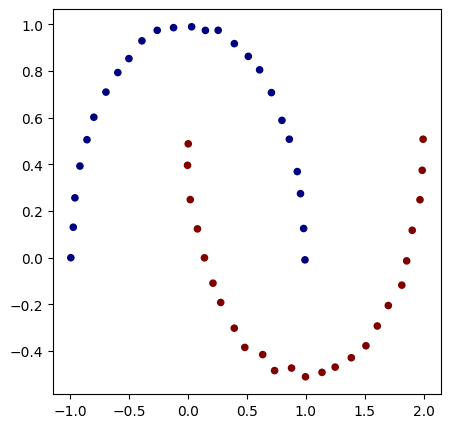

In [2]:
# Use sample datset
X, y = make_moons(n_samples=50, noise=0.01)
y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [3]:
# Define model
model = MLP(2, [16, 16, 1])
print(model)
print("Number of parameters: ", len(model.parameters()))


Number of parameters:  337


In [4]:
# loss function
def loss(batch_size=None):
    
    # Dataloader
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss.data, acc)

1.0127144669505201 0.5


In [5]:
# Define training loop
for epoch in range(100):
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    # learning_rate = 0.5 - 0.9*epoch/100
    learning_rate = 0.01
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.data:.4f}, lr {learning_rate:.4f}')

Epoch 0, Loss: 1.0127, lr 0.0100
Epoch 10, Loss: 1.0127, lr 0.0100
Epoch 20, Loss: 1.0127, lr 0.0100
Epoch 30, Loss: 1.0127, lr 0.0100
Epoch 40, Loss: 1.0127, lr 0.0100
Epoch 50, Loss: 1.0127, lr 0.0100
Epoch 60, Loss: 1.0127, lr 0.0100
Epoch 70, Loss: 1.0127, lr 0.0100
Epoch 80, Loss: 1.0127, lr 0.0100
Epoch 90, Loss: 1.0127, lr 0.0100


(-1.51074725387811, 1.98925274612189)

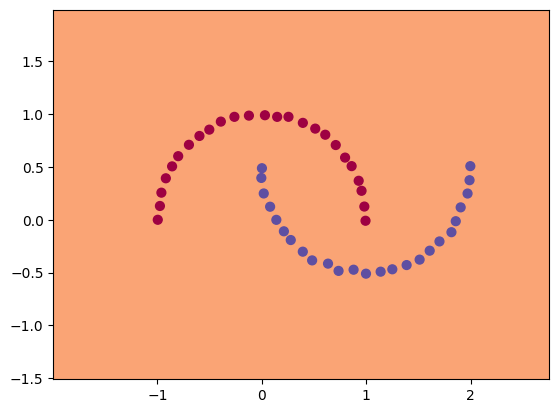

In [6]:

# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())